In [1]:
!pip install git+https://github.com/florencejt/fusilli.git
!pip install nibabel

  Cloning https://github.com/florencejt/fusilli.git to c:\users\bnish\appdata\local\temp\pip-req-build-l20hfh24
  Resolved https://github.com/florencejt/fusilli.git to commit bbd29f94f9ec43c22d8e15e87a05b86fad25752f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/florencejt/fusilli.git 'C:\Users\bnish\AppData\Local\Temp\pip-req-build-l20hfh24'
  Running command git submodule update --init --recursive -q


In [2]:
import os
import torch
import pandas as pd
from pathlib import Path
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import tensor
import numpy as np
import nibabel as nib
import glob

from fusilli.data import prepare_fusion_data
from fusilli.train import train_and_save_models
from fusilli.fusionmodels.tabularimagefusion.concat_img_maps_tabular_maps import ConcatImageMapsTabularMaps
from fusilli.eval import RealsVsPreds, ConfusionMatrix

In [3]:
pip show torch

Name: torch
Version: 2.6.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: C:\Users\bnish\anaconda3\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, setuptools, sympy, typing-extensions
Required-by: fusilli, lightning, pytorch-lightning, torchmetrics, torchvision
Note: you may need to restart the kernel to use updated packages.


In [4]:
#print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
import sys
import torch
print("Python version:", sys.version)
# print("Torch version:", torch._version_)
print("Torch CUDA available:", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")
# print("TorchMetrics version:", torchmetrics._version_)
# print("Lightning version:", lightning._version_)
# print("WandB version:", wandb._version_)
# print("Fusilli version:", fusilli._version_)


Python version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
Torch CUDA available: False
CUDA device: CPU only


In [5]:
## Data preprocessing
print('cwd (base):', os.getcwd(),'\n')

# open and load csv
base_dir = Path(r"C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0\ATLAS_2")  
meta_xlsx  = base_dir / "20220425_ATLAS_2.0_MetaData.xlsx"          
train_dir  = base_dir / "Training"  
test_dir   = base_dir / "Testing" 

meta_df = pd.read_excel(meta_xlsx)

cwd (base): C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0 



In [6]:
def norm_sub_id(x):
    s = str(x).strip()
    return s.replace("sub-","")

meta_df["ID"] = meta_df["Subject ID"].apply(norm_sub_id)

In [7]:
# T1w image paths
def find_t1_for_subject(sub_id: str) -> str | None:
    patterns = [
        str(train_dir / f"**/*{sub_id}*/*anat/*T1w*.nii*"),
        str(train_dir / f"**/*{sub_id}*/*T1w*.nii*"),
        str(train_dir / f"**/*{sub_id}*T1w*.nii*"),
    ]
    for pat in patterns:
        hits = glob.glob(pat, recursive=True)
        if hits:
            return hits[0]
    return None

meta_df["image_path"] = meta_df["ID"].apply(find_t1_for_subject)

before = len(meta_df)
meta_df = meta_df.dropna(subset=["image_path"]).reset_index(drop=True)
after = len(meta_df)
print(f"Fixed T1w paths for {after}/{before} subjects in Training")

Fixed T1w paths for 655/655 subjects in Training


In [8]:
# Add labels
def map_hemi(x):
    s = str(x).strip().lower()
    if s.startswith("l"): #Left
        return 0
    if s.startswith("r"): #Right
        return 1
    return 2 #Other

if "Primary Stroke Hemisphere" in meta_df.columns:
    meta_df["prediction_label"] = meta_df["Primary Stroke Hemisphere"].apply(map_hemi)
    
else:
    if "Lesion Volume" not in meta_df.columns:
        raise ValueError("Neither 'Primary Stroke Hemisphere' nor 'Lesion Volume' in MetaData.xlsx.")
    q = meta_df["Lesion Volume"].quantile([0.33, 0.66]).values
    
    def size_bin(v):
        if v <= q[0]: return 0
        if v <= q[1]: return 1
        return 2
        
    meta_df["prediction_label"] = meta_df["Lesion Volume"].apply(size_bin)
    print("Using 3-class lesion size bins from 'Lesion Volume'.")

In [9]:
# New csv for mapped data for later
mapped_csv = base_dir / "mapped_atlas_metadata.csv"
meta_df.to_csv(mapped_csv, index=False)
print(f"Saved mapped metadata in {mapped_csv}...\n")
print(meta_df[["ID","image_path","Primary Stroke Hemisphere" if "Primary Stroke Hemisphere" in meta_df.columns else "Lesion Volume"]].head())

Saved mapped metadata in C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0\ATLAS_2\mapped_atlas_metadata.csv...

         ID                                         image_path  \
0  r001s001  C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0...   
1  r001s002  C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0...   
2  r001s003  C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0...   
3  r001s004  C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0...   
4  r001s005  C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0...   

  Primary Stroke Hemisphere  
0                     Right  
1                     Right  
2                     Right  
3                      Left  
4                      Left  


In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

def middle_axial_slice_2uint8(nifti_path: Path) -> Image.Image:
    ni = nib.load(str(nifti_path))
    data = ni.get_fdata()
    z = data.shape[2] // 2
    slice2d = data[:, :, z]
    lo, hi = np.percentile(slice2d[np.isfinite(slice2d)], [1, 99])
    slice2d = np.clip((slice2d - lo) / (hi - lo + 1e-8), 0, 1)
    slice2d = (slice2d * 255.0).astype(np.uint8)
    return Image.fromarray(slice2d)  # single-channel

df = pd.read_csv(mapped_csv)
images, valid_idx = [], []
for i, row in tqdm(df.iterrows(), total=len(df)):
    p = Path(row["image_path"])
    if not p.exists(): continue
    pil_img = middle_axial_slice_2uint8(p)
    images.append(transform(pil_img))   # [1, 224, 224]
    valid_idx.append(i)

image_tensor = torch.stack(images)      # [N, 1, 224, 224]
torch.save(image_tensor, base_dir / "images.pt")
df = df.loc[valid_idx].reset_index(drop=True)
df.to_csv(mapped_csv, index=False)
print("Saved image tensor:", base_dir / "images.pt", "shape:", image_tensor.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 655/655 [5:36:02<00:00, 30.78s/it]


Saved image tensor: C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0\ATLAS_2\images.pt shape: torch.Size([655, 1, 224, 224])


In [11]:
# df_numeric = pd.read_csv(mapped_csv)
# df_numeric["prediction_label"] = pd.to_numeric(df_numeric["prediction_label"], errors="coerce").astype("Int64")
# non_feature_cols = {"ID", "prediction_label"}

# def to_numeric_series(s: pd.Series) -> pd.Series:
#     if s.dtype.kind in "biufc":
#         return s
#     str_s = s.astype(str).str.strip()
#     first_number = str_s.str.extract(r"([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)", expand=False)
#     out = pd.to_numeric(first_number, errors="coerce")
#     return out

# clean = {}
# for c in df_numeric.columns:
#     if c in non_feature_cols:
#         clean[c] = df_numeric[c]
#     else:
#         clean[c] = to_numeric_series(df_numeric[c])

# clean = pd.DataFrame(clean)

# feature_cols = [c for c in clean.columns if c not in non_feature_cols]
# min_non_na = max(10, int(0.6 * len(clean))) 
# kept = []
# dropped = []
# for c in feature_cols:
#     if clean[c].notna().sum() >= min_non_na:
#         kept.append(c)
#     else:
#         dropped.append(c)
# clean = clean[["ID", "prediction_label"] + kept].dropna().reset_index(drop=True)

# clean[kept] = clean[kept].astype("float32")
# clean["prediction_label"] = clean["prediction_label"].astype("int64")

# tabular_csv = base_dir / "mapped_atlas_numeric.csv"
# clean.to_csv(tabular_csv, index=False)

# print(f"[Tabular cleanup] kept {len(kept)} numeric feature columns; dropped {len(dropped)}: {dropped}")
# print(f"[Tabular cleanup] final shape: {clean.shape}")



# data_paths = {
#     "tabular1": str(tabular_csv),
#     "tabular2": "",
#     "image": str(base_dir / "images.pt"),
# }

In [70]:
import re
df_numeric = pd.read_csv(mapped_csv)



df_numeric["prediction_label"] = pd.to_numeric(df_numeric["prediction_label"], errors="coerce").astype("Int64")


hemi_col   = "Primary Stroke Hemisphere"
loc_col   = "Primary Stroke Location"
days_col = "Days Post Stroke"
selected_cols = [hemi_col, loc_col, days_col] 

days = pd.to_numeric(df_numeric[days_col], errors="coerce")

# Hemisphere: Left=0, Right=1, OUnknown=2
def hemi_encode(x):
    s = str(x).strip().lower()
    if s.startswith("l"): return 0  
    if s.startswith("r"): return 1  
    return 2

hemi_code = df_numeric[hemi_col].apply(hemi_encode).astype("float32")

loc_raw = df_numeric[loc_col].astype(str)

def normalize_loc_string(s: str) -> list[str]:
    s = s.strip().lower()
    if not s or s in {"nan", "none"}:
        return []
    # unify separators ; and / into commas
    s = re.sub(r"[;/]", ",", s)
    # remove characters that are not letters, commas, or spaces
    s = re.sub(r"[^a-z, ]", "", s)
    parts = [p.strip() for p in s.split(",") if p.strip()]
    # unique tokens per row
    return sorted(set(parts))

vocab = set()
for row in loc_raw:
    vocab.update(normalize_loc_string(row))
vocab = sorted(vocab)
print("Detected stroke location categories:", vocab)

def slugify(loc_name: str) -> str:
    slug = re.sub(r"[^a-z0-9]+", "_", loc_name.lower()).strip("_")
    return slug or "unknown"

loc_feature_names = []
for loc in vocab:
    col_name = f"loc_{slugify(loc)}"
    loc_feature_names.append(col_name)

    def has_loc(row_str, loc=loc):
        tokens = normalize_loc_string(row_str)
        return float(loc in tokens)

    df_numeric[col_name] = loc_raw.apply(has_loc).astype("float32")

clean = pd.DataFrame({
    "ID": df_numeric["ID"],
    "prediction_label": df_numeric["prediction_label"],
    "days_post_stroke": days,
    "hemi_code": hemi_code,
})
for col_name in loc_feature_names:
    clean[col_name] = df_numeric[col_name]

clean["prediction_label"] = pd.to_numeric(clean["prediction_label"], errors="coerce")
clean = clean.dropna(subset=["prediction_label", "days_post_stroke", "hemi_code"]).reset_index(drop=True)
feature_cols = ["days_post_stroke", "hemi_code"] + loc_feature_names
clean["prediction_label"] = clean["prediction_label"].astype("int64")
clean[feature_cols] = clean[feature_cols].astype("float32")


tabular_csv = base_dir / "mapped_atlas_numeric.csv"
clean.to_csv(tabular_csv, index=False)

print(f"[Tabular cleanup] final shape: {clean.shape}")
print("[Tabular cleanup] example rows:")
print(clean)

Detected stroke location categories: ['basal ganglia', 'brainstem', 'caudate', 'cerebellum', 'frontal lobe', 'hippocampus', 'insula', 'occipital lobe', 'pallidum', 'parietal lobe', 'pons', 'putamen', 'temporal lobe', 'thalamus']
[Tabular cleanup] final shape: (549, 18)
[Tabular cleanup] example rows:
           ID  prediction_label  days_post_stroke  hemi_code  \
0    r001s001                 1             471.0        1.0   
1    r001s002                 1             669.0        1.0   
2    r001s003                 1             709.0        1.0   
3    r001s004                 0             871.0        0.0   
4    r001s005                 0            1917.0        0.0   
..        ...               ...               ...        ...   
544  r052s026                 0             518.5        0.0   
545  r052s027                 1            1555.5        1.0   
546  r052s029                 1             579.5        1.0   
547  r052s031                 0            3690.5        0

In [40]:
print(clean)

Empty DataFrame
Columns: [ID, prediction_label, Primary Stroke Hemisphere, Primary Stroke Location, Days Post Stroke]
Index: []


In [72]:
output_paths = {
    "checkpoints": "outputs/checkpoints",
    "losses": "outputs/losses",
    "figures": "outputs/figures",
}
for p in output_paths.values():
    os.makedirs(p, exist_ok=True)

In [74]:
counts = clean['prediction_label'].value_counts().sort_index()
inv_freq = (counts.sum() / (len(counts) * counts)).values
class_weights = torch.tensor(inv_freq, dtype=torch.float32)

data_module = prepare_fusion_data(
    prediction_task="multiclass",
    fusion_model=ConcatImageMapsTabularMaps,
    data_paths=data_paths,
    output_paths=output_paths,
    batch_size=8,
    test_size=0.2,
    multiclass_dimensions=3,
    image_downsample_size=(224, 224),
    num_workers=4
)

In [12]:
# data_module = prepare_fusion_data(
#     prediction_task="multiclass",
#     fusion_model=ConcatImageMapsTabularMaps,
#     data_paths=data_paths,
#     output_paths=output_paths,
#     batch_size=8,
#     test_size=0.2,
#     multiclass_dimensions=3,
#     image_downsample_size=(224, 224),  # default for CNNs
#     num_workers=4
# )

In [13]:
# df_counts = df_numeric['prediction_label'].value_counts()
# weights = df_numeric['prediction_label'].apply(lambda x: 1/class_counts[x]).values
# pos_weight = tensor(weight_for_0)

In [14]:
# import torch
# import pandas as pd

# counts = df_numeric['prediction_label'].value_counts().sort_index()

# inv_freq = (counts.sum() / (len(counts) * counts)).values
# class_weights = torch.tensor(inv_freq, dtype=torch.float)
# print("class_weights [w0,w1,w2]:", class_weights.tolist())

class_weights [w0,w1,w2]: [0.7426303625106812, 0.7554786801338196, 3.032407522201538]


In [ ]:
trained_model = train_and_save_models(
    data_module=data_module,
    fusion_model=ConcatImageMapsTabularMaps,
    training_modifications={
        "accelerator": "cpu",
        "devices": 1,       # number of GPUs
         "loss_params": {
        #     "pos_weight": pos_weight
        "weight": class_weights },
        # "precision": 16,    # mixed precision
    },
    max_epochs=100,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\bnish\anaconda3\Lib\site-packages\lightning\fabric\loggers\csv_logs.py:268: Experiment logs directory outputs/losses\ConcatImageMapsTabularMaps exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
C:\Users\bnish\anaconda3\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\bnish\Downloads\ATLAS_R2.0\ATLAS_R2.0\outputs\checkpoints exists and is not empty.

  | Name  | Type                       | Params | Mode 
-------------------------------------------------------------
0 | model | ConcatImageMapsTabularMaps | 2.8 M  | train
-------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.234    Total estimated model params size (MB)
47        Modules in train mode
0         Modules in 

Training: |                                                                                      | 0/? [00:00<…

C:\Users\bnish\anaconda3\Lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
C:\Users\bnish\anaconda3\Lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


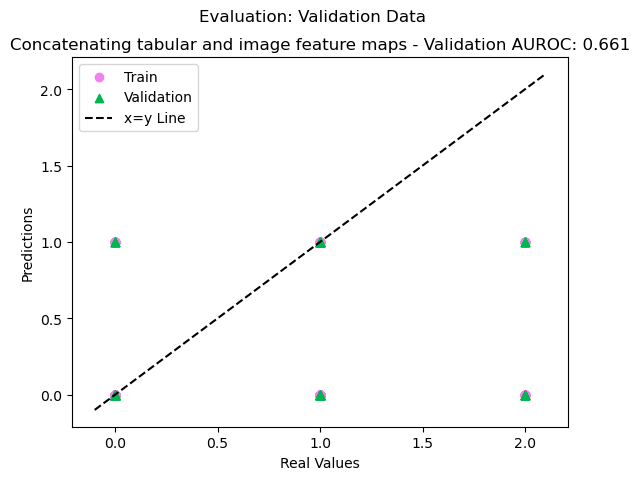

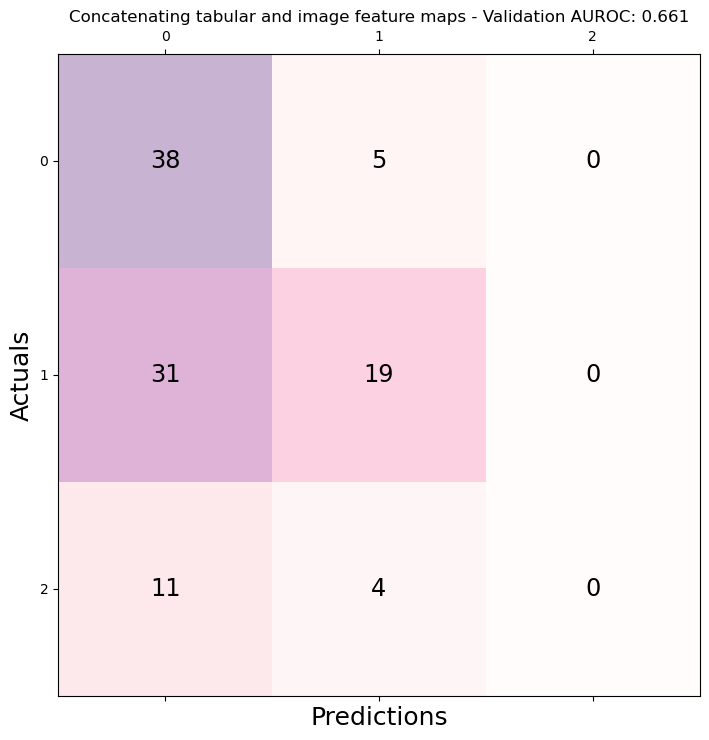

In [17]:
RealsVsPreds.from_final_val_data(trained_model)
ConfusionMatrix.from_final_val_data(trained_model)
plt.show()